# Heat equation

## imports

In [114]:
import numpy as np
import pandas as pd
import scipy

In [115]:
import tqdm
import cv2
import matplotlib.pyplot as plt
from IPython.display import HTML
from functools import lru_cache

## initialization

In [141]:
X_max = 120
Y_max = 70
X_min = Y_min = 0

NUMBER_X = 240
NUMBER_Y = 140

In [142]:
X_RANGE = np.linspace(X_min, X_max, NUMBER_X)
Y_RANGE = np.linspace(Y_min, Y_max, NUMBER_Y)

X_STEP = X_RANGE[1] - X_RANGE[0]
Y_STEP = Y_RANGE[1] - Y_RANGE[0]

In [143]:
X, Y = np.meshgrid(X_RANGE, Y_RANGE, indexing='ij')

T = np.zeros_like(X)
lambdas = np.ones_like(X)
source_c = np.zeros_like(X) 
source_p = np.zeros_like(X)

In [144]:
def calculate_coefficients(alpha, beta, current_u, upper_u, lower_u, s_c, s_p, current_lambdas, upper_lambdas, lower_lambdas, kind):
    """makes Thomas algorithm for longituginal and transversal kinds"""
    if kind == 'longituginal':
        size_x = X_STEP
        size_y = Y_STEP
        
    elif kind == 'transversal':
        size_x = Y_STEP
        size_y = X_STEP

    a  = np.roll(current_lambdas, 1) / (np.roll(current_lambdas, 1) + current_lambdas) / size_x ** 2
    b  = np.roll(current_lambdas, -1) / (np.roll(current_lambdas, -1) + current_lambdas) / size_x ** 2
    c = (
        ((np.roll(current_lambdas, -1) + np.roll(current_lambdas, 1)) * current_lambdas + 
        2 * np.roll(current_lambdas, -1) * np.roll(current_lambdas, 1)) /
        (np.roll(current_lambdas, -1) + current_lambdas) / 
        (np.roll(current_lambdas, 1) + current_lambdas) /
        size_x ** 2 +
        ((upper_lambdas + lower_lambdas) * current_lambdas + 
        2 * upper_lambdas * lower_lambdas) /
        (upper_lambdas + current_lambdas) / 
        (lower_lambdas + current_lambdas) /
        size_y ** 2 +
        s_p
    )
    d = (
        upper_lambdas / (upper_lambdas + current_lambdas)
        * upper_u / size_y ** 2 + 
        lower_lambdas / (lower_lambdas + current_lambdas)
        * lower_u / size_y ** 2 -
        s_c / (2 * current_lambdas)
    )

    for i in range(1, len(current_u)-1):
        alpha[i+1] = b[i] / (c[i] - alpha[i] * a[i])
        beta[i+1] = (a[i] * beta[i] + d[i]) / (c[i] - alpha[i] * a[i])
        
    return alpha, beta
    
def thomas_algorithm_trans(U, S_c, S_p,lambdas):
    
    for k in range(1, len(U[1,:]) - 1):  
        
        lambdas, U = first_area(lambdas, U)
        lambdas, U, S_c, S_p = second_area(lambdas, U, S_c, S_p)
        lambdas, U = third_area(lambdas, U)
        lambdas, S_c = fourth_area(lambdas, S_c)
        lambdas, S_c, S_p = fifth_area(lambdas, S_c, S_p)
    
        current_u = U[:, k]
        upper_u = U[:, k+1]
        lower_u = U[:, k-1]
        
        s_c = S_c[:, k]
        s_p = S_p[:, k]
        
        current_lambdas = lambdas[:, k]
        upper_lambdas = lambdas[:, k+1]
        lower_lambdas = lambdas[:, k-1]
        
        alpha = np.zeros_like(current_u)
        beta = np.zeros_like(current_u)

        alpha[1] = 0
        beta[1] = Q_LEFT * X_STEP / current_lambdas[0]
        

        
        kind = 'transversal'
        alpha, beta = calculate_coefficients(alpha, beta, current_u, upper_u, lower_u, s_c, s_p, 
                                             current_lambdas, upper_lambdas, lower_lambdas, kind)
        
        U[-1, k] = T_RIGHT
        
        for m in reversed(range(0, len(U[:, 1]) - 1)):
            U[m, k] = alpha[m+1] * U[m+1, k] + beta[m+1]
            
    return U

def thomas_algorithm_long(U, S_c, S_p, lambdas):
    for m in range(1, len(U[:, 1]) - 1):
                
        lambdas, U = first_area(lambdas, U)
        lambdas, U, S_c, S_p = second_area(lambdas, U, S_c, S_p)
        lambdas, U = third_area(lambdas, U)
        lambdas, S_c = fourth_area(lambdas, S_c)
        lambdas, S_c, S_p = fifth_area(lambdas, S_c, S_p)

        current_u = U[m, :]
        upper_u = U[m+1, :]
        lower_u = U[m-1, :]

        s_c = S_c[m, :]
        s_p = S_p[m, :]

        current_lambdas = lambdas[m, :]
        upper_lambdas = lambdas[m+1, :]
        lower_lambdas = lambdas[m-1, :]

        alpha = np.zeros_like(current_u)
        beta = np.zeros_like(current_u)

        alpha[1] = 0
        beta[1] = T_LOWER


        kind = 'longituginal'
        alpha, beta = calculate_coefficients(alpha, beta, current_u, upper_u, lower_u, s_c, s_p, 
                                             current_lambdas, upper_lambdas, lower_lambdas, kind)
        
        U[m, -1] = (Y_STEP * Q_UPPER / current_lambdas[-1] + beta[-1]) / (1 - alpha[-1])

        for k in reversed(range(0, len(U[1,:]) - 1)):
            U[m, k] = alpha[k+1] * U[m, k+1] + beta[k+1]
            
    U[-1, k] = T_RIGHT

    return U
    
def heatmap2d(arr: np.ndarray, interpolation=None):
    plt.imshow(arr.T, cmap='hot', interpolation=interpolation)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Temperature map')
    ax = plt.gca()
    ax.invert_yaxis()

## boundary conditions

<img src="task3.png">

### outlet conditions

In [145]:
T_LOWER = 0         # lower bound
Q_UPPER = 5         # upper bound
Q_LEFT = 0          # left bound
T_RIGHT = 200       # right bound

### 1

In [146]:
def first_area(lambdas, U):
    T_edge = 100
    lambda_edge = 10 ** 20

    bound_size_x = NUMBER_X // 4
    bound_size_y = NUMBER_Y // 4

    lambdas[0 : bound_size_x, 0 : bound_size_y] = lambda_edge
    U[0 : bound_size_x, 0] = T_edge
    U[0 : bound_size_x, bound_size_y] = T_edge
    U[0, 0 : bound_size_y] = T_edge
    U[bound_size_x, 0 : bound_size_y] = T_edge
    return lambdas, U

### 2

In [147]:
@lru_cache(maxsize=None)
def generate_masks():
    mask_circle, mask_ring = np.zeros_like(T), np.zeros_like(T)
    
    radius = NUMBER_Y // 6
    
    cv2.circle(mask_circle, (NUMBER_Y // 2, NUMBER_X // 2), radius, 1, cv2.FILLED)
    cv2.circle(mask_ring, (NUMBER_Y // 2, NUMBER_X // 2), radius, 1)
    
    mask_circle = mask_circle.astype(bool)
    mask_ring = mask_ring.astype(bool)
    
    return mask_ring, mask_circle

def second_area(lambdas, U, S_c, S_p):
    T_edge = 300
    lambda_edge = 10 ** 15
    M_edge = 10 ** 20
    
    mask_ring, mask_circle = generate_masks()
    lambdas[mask_circle] = lambda_edge
    S_c[mask_circle] = M_edge
    S_p[mask_circle] = - M_edge
    
    U[mask_ring] = T_edge
    
    return lambdas, U, S_c, S_p

### 3

In [148]:
def third_area(lambdas, U):
    q_edge = 0
    lambda_edge = 1e-5

    bound_size_x = NUMBER_X // 4
    bound_size_y = NUMBER_Y // 4
    
    lambdas[0 : bound_size_x, - bound_size_y: -1] = lambda_edge
    
    return lambdas, U

### 4

In [149]:
def fourth_area(lambdas, S_c):
    q_edge = 10
    lambda_edge = 1e-5

    bound_size_x = NUMBER_X // 4
    bound_size_y = NUMBER_Y // 4
    
    lambdas[- bound_size_x : -1, - bound_size_y: -1] = lambda_edge
    S_c[- bound_size_x - 1, - bound_size_y: -1] = q_edge * X_STEP * Y_STEP
    
    return lambdas, S_c

### 5

In [150]:
def fifth_area(lambdas, S_c, S_p):
    T_edge = 150
    lambda_edge = 1e-5

    bound_size_x = NUMBER_X // 4
    bound_size_y = NUMBER_Y // 4
    
    lambdas[- bound_size_x : -1, 0 : bound_size_y] = lambda_edge
    S_c[- bound_size_x : -1, bound_size_y] = T_edge * X_STEP * Y_STEP
    S_p[- bound_size_x : -1, bound_size_y] = T_edge * X_STEP * Y_STEP
    
    return lambdas, S_c, S_p

## main procedure

In [151]:
with tqdm.tqdm_notebook() as pbar:
    while True:
        T_prev = T.copy()

        T = thomas_algorithm_trans(T, source_c, source_p, lambdas)
        T = thomas_algorithm_long(T, source_c, source_p, lambdas)

        T_difference = abs(T_prev - T)

        if np.amax(T_difference) < 0.1:
            break

        pbar.update(1)
        pbar.set_description(f"T diff: {T_difference.max():.5f}")
        pbar.refresh()

## vizualization

[Text(0, 0, '-10'),
 Text(0, 0, '0'),
 Text(0, 0, '10'),
 Text(0, 0, '20'),
 Text(0, 0, '30'),
 Text(0, 0, '40'),
 Text(0, 0, '50'),
 Text(0, 0, '60'),
 Text(0, 0, '70')]

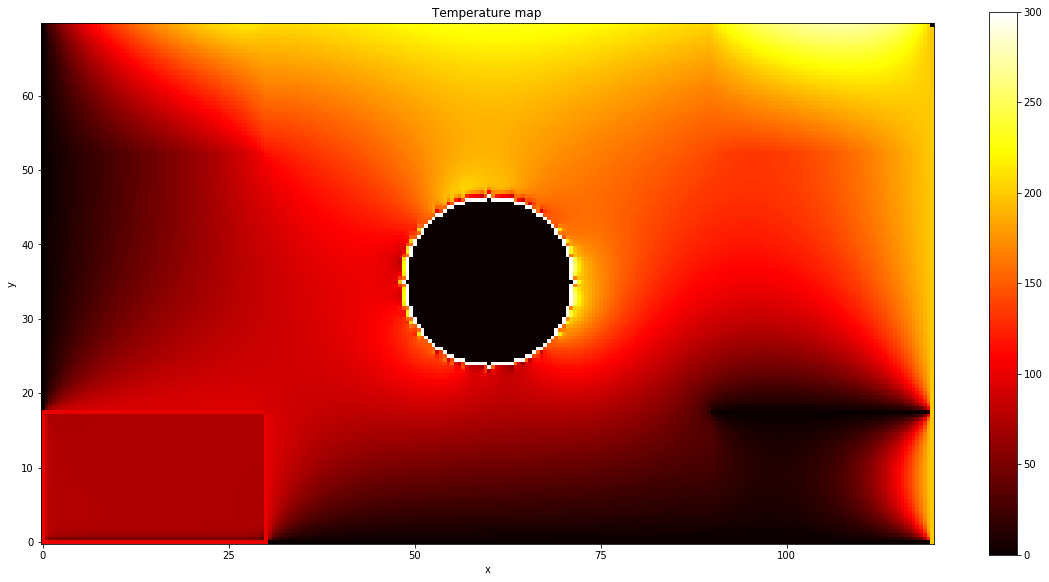

In [152]:
fig, ax = plt.subplots(figsize=(20, 10))
heatmap2d(T_prev)

ticks = ax.get_xticks()
ax.set_xticklabels([str(int(X_min + x * (X_max - X_min) // (NUMBER_X)))
                    for x in ticks])

ticks = ax.get_yticks()
ax.set_yticklabels([str(int(Y_min + x * (Y_max - Y_min) // (NUMBER_Y)))
                    for x in ticks])
